In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2002 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_02(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata02 = pd.read_csv("perlist02_h.csv")
    f = perdata02['f']
    per = perdata02['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata02)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m02=Minuit(twi_minus_loglikelihood_02,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,1), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,10),
         errordef=1)

m02.migrad()

pprint(m02.fval)

FCN = 4723.837438388619 
 TOTAL NCALL = 449 
 NCALLS = 449 
 
 
 EDM = 1.3500633298194623e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,0.341816,0.0246258,,,-3,1,No
1,log_f_b,-6.25044,4.60427,,,-7,-2,No
2,alpha_H,1,0.00947898,,,1,5,No
3,poisson,9.99999,0.943486,,,0,10,No


4723.837438388619


In [4]:
perdata02 = pd.read_csv("perlist02_h.csv")
f_02 = perdata02['f']
per_02 = perdata02['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m02.values[0],m02.values[1],m02.values[2],m02.values[3]

model_02 = []
R_obs_02 = []
T_SSE_obs_02 = 0
f_length_02 = len(f_02)
for i in range(f_length_02):
    model_02.append(((f_02[i]**(-alpha_L))/(1+(f_02[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_02.append(2*per_02[i]/model_02[i])
    T_SSE_obs_02 += (((per_02[i]-model_02[i])/model_02[i])**2)
    
# 两个统计量
T_R_obs_02 = max(R_obs_02)
print ("T_R =", T_R_obs_02)
print ("T_SSE =", T_SSE_obs_02)

T_R = 26.38364574633319
T_SSE = 603.362886287053


In [5]:
# 5000条光变曲线

df = 0.01/f_length_02
N = 2*f_length_02
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_02]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_02):
        R_simu.append(2*per_simu[i]/model_02[i])
        T_SSE_simu += (((per_simu[i]-model_02[i])/model_02[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_02:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_02:
        n_TSSE += 1

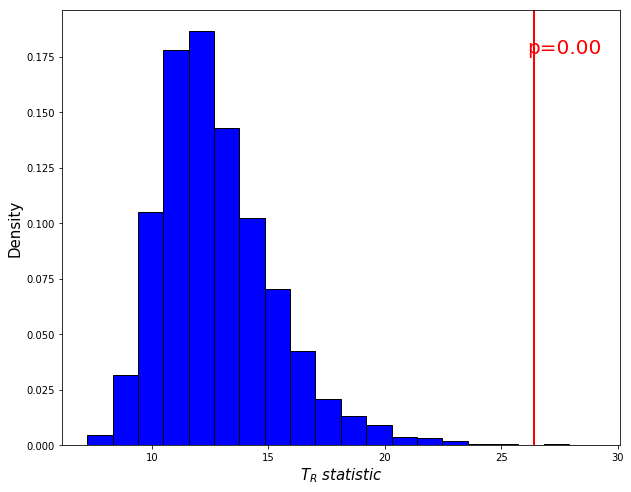

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

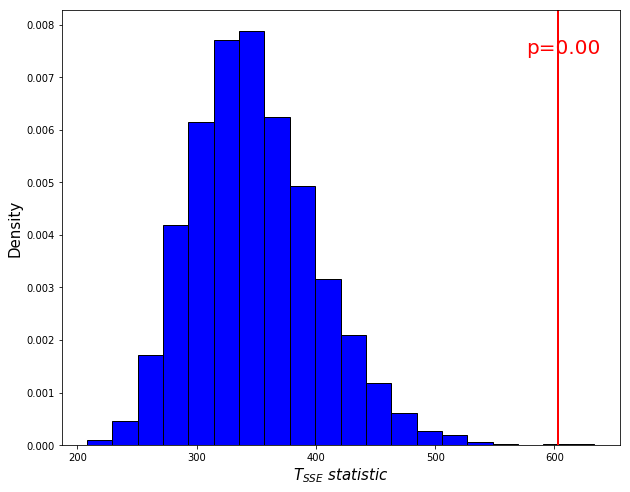

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_02, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2011(4) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_114(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata114 = pd.read_csv("perlist114_h.csv")
    f = perdata114['f']
    per = perdata114['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata114)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m114=Minuit(twi_minus_loglikelihood_114,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,1), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,10),
         errordef=1)

m114.migrad()

pprint(m114.fval)

FCN = 13643.137111327309 
 TOTAL NCALL = 288 
 NCALLS = 288 
 
 
 EDM = 5.3904611089560245e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,0.0831642,0.0144776,,,-3,1,No
1,log_f_b,-4.79032,3.42336,,,-7,-2,No
2,alpha_H,1,0.00208859,,,1,5,No
3,poisson,10,0.18952,,,0,10,No


13643.137111327309


In [10]:
perdata114 = pd.read_csv("perlist114_h.csv")
f_114 = perdata114['f']
per_114 = perdata114['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m114.values[0],m114.values[1],m114.values[2],m114.values[3]

model_114 = []
R_obs_114 = []
T_SSE_obs_114 = 0
f_length_114 = len(f_114)
for i in range(f_length_114):
    model_114.append(((f_114[i]**(-alpha_L))/(1+(f_114[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_114.append(2*per_114[i]/model_114[i])
    T_SSE_obs_114 += (((per_114[i]-model_114[i])/model_114[i])**2)
    
# 两个统计量
T_R_obs_114 = max(R_obs_114)
print ("T_R =", T_R_obs_114)
print ("T_SSE =", T_SSE_obs_114)

T_R = 22.454039323752596
T_SSE = 1793.8085917992976


In [11]:
# 5000条光变曲线

df = 0.01/f_length_114
N = 2*f_length_114
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_114]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_114):
        R_simu.append(2*per_simu[i]/model_114[i])
        T_SSE_simu += (((per_simu[i]-model_114[i])/model_114[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_114:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_114:
        n_TSSE += 1

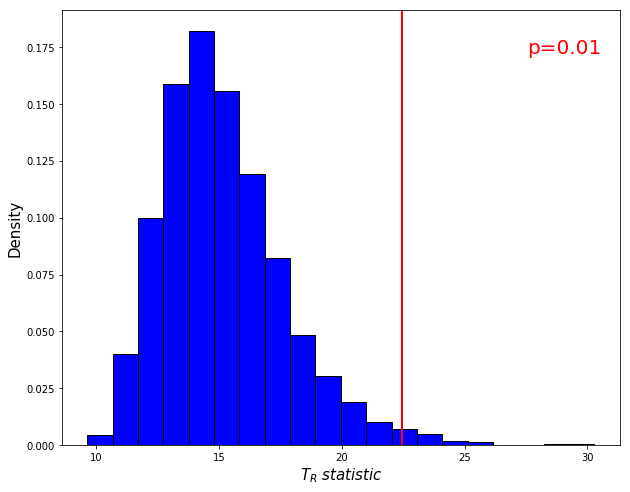

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_114, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

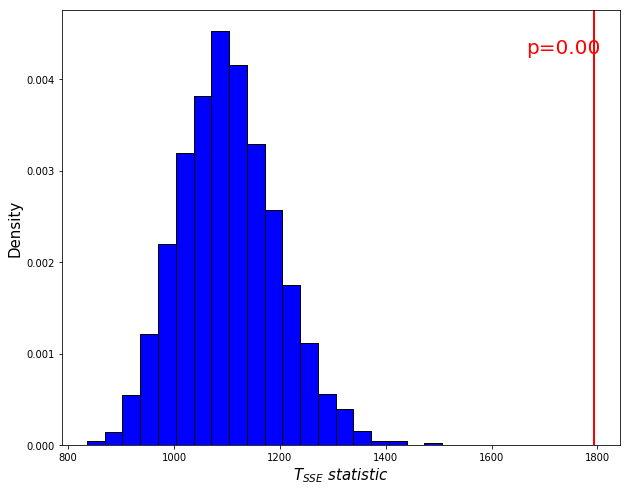

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_114, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2016(2) 统计分析

In [14]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_162(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata162 = pd.read_csv("perlist162_h.csv")
    f = perdata162['f']
    per = perdata162['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata162)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [15]:
m162=Minuit(twi_minus_loglikelihood_162,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.02,error_poisson=0.02,
         limit_log_A=(-3,1), limit_log_f_b=(-7,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,10),
         errordef=1)

m162.migrad()

pprint(m162.fval)

FCN = 14556.459323811021 
 TOTAL NCALL = 343 
 NCALLS = 343 
 
 
 EDM = 3.224764746698622e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,0.0162871,0.0141003,,,-3,1,No
1,log_f_b,-3.25993,3.62377,,,-7,-2,No
2,alpha_H,1,0.00303902,,,1,5,No
3,poisson,10,0.145266,,,0,10,No


14556.459323811021


In [16]:
perdata162 = pd.read_csv("perlist162_h.csv")
f_162 = perdata162['f']
per_162 = perdata162['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m162.values[0],m162.values[1],m162.values[2],m162.values[3]

model_162 = []
R_obs_162 = []
T_SSE_obs_162 = 0
f_length_162 = len(f_162)
for i in range(f_length_162):
    model_162.append(((f_162[i]**(-alpha_L))/(1+(f_162[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_162.append(2*per_162[i]/model_162[i])
    T_SSE_obs_162 += (((per_162[i]-model_162[i])/model_162[i])**2)
    
# 两个统计量
T_R_obs_162 = max(R_obs_162)
print ("T_R =", T_R_obs_162)
print ("T_SSE =", T_SSE_obs_162)

T_R = 27.337328967287768
T_SSE = 2161.230346463179


In [17]:
# 5000条光变曲线

df = 0.01/f_length_162
N = 2*f_length_162
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_162]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_162):
        R_simu.append(2*per_simu[i]/model_162[i])
        T_SSE_simu += (((per_simu[i]-model_162[i])/model_162[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_162:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_162:
        n_TSSE += 1

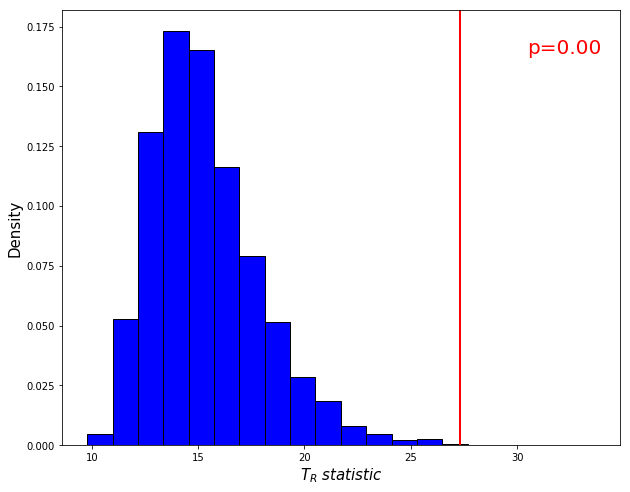

In [18]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_162, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

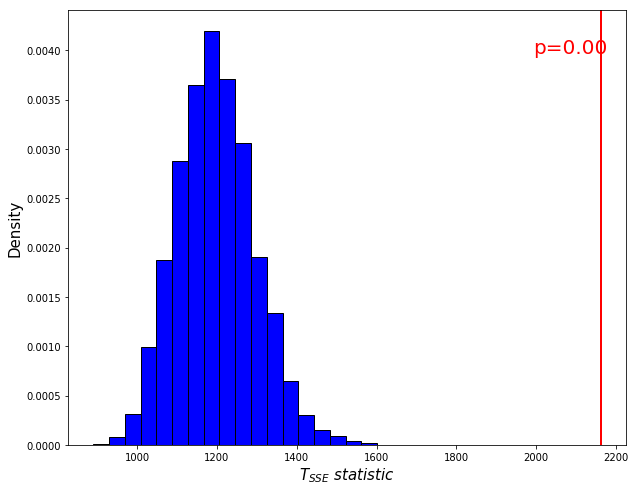

In [19]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_162, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 综合结果

In [11]:
data02 = pd.read_csv("energy_iras13224_02.csv")  
x02 = data02['x']
y02 = data02['y']
xerr02 = data02['xerr']
yerr02 = data02['yerr']

data114 = pd.read_csv("energy_iras13224_114.csv")  
x114 = data114['x']
y114 = data114['y']
xerr114 = data114['xerr']
yerr114 = data114['yerr']

data162 = pd.read_csv("energy_iras13224_162.csv")  
x162 = data162['x']
y162 = data162['y']
xerr162 = data162['xerr']
yerr162 = data162['yerr']

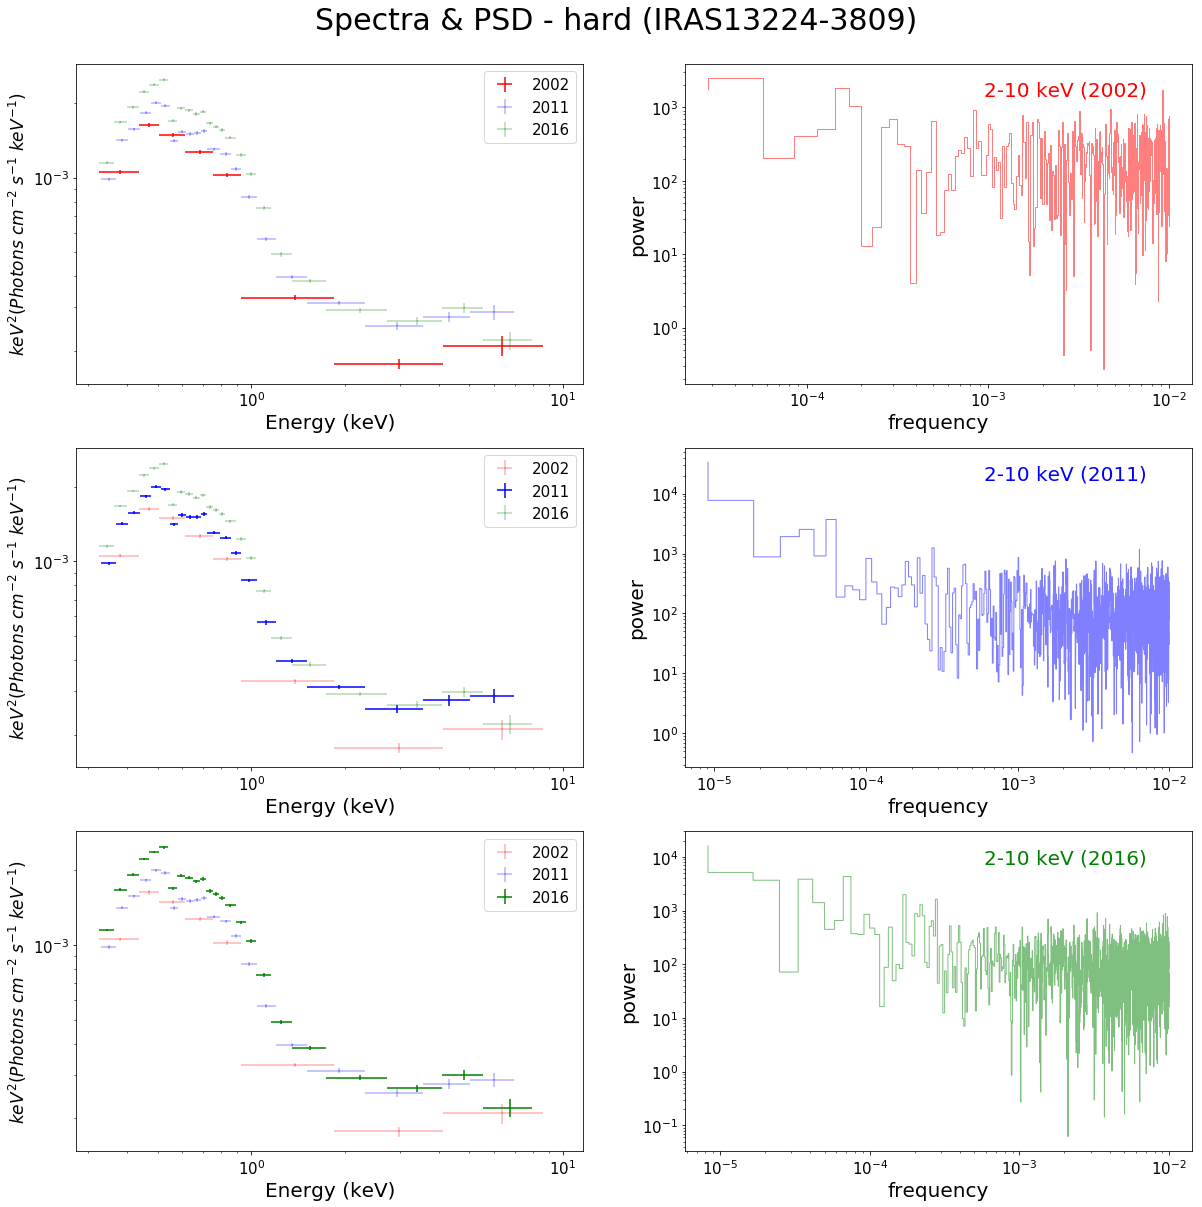

In [12]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)



ax1.loglog()
ax1.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', label='2002')
ax1.errorbar(x114, y114, yerr=yerr114, xerr=xerr114, fmt=',b', alpha=0.3, label='2011')
ax1.errorbar(x162, y162, yerr=yerr162, xerr=xerr162, fmt=',g', alpha=0.3, label='2016')
ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', alpha=0.3, label='2002')
ax3.errorbar(x114, y114, yerr=yerr114, xerr=xerr114, fmt=',b', label='2011')
ax3.errorbar(x162, y162, yerr=yerr162, xerr=xerr162, fmt=',g', alpha=0.3, label='2016')
ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)

ax5.loglog()
ax5.errorbar(x02, y02, yerr=yerr02, xerr=xerr02, fmt=',r', alpha=0.3, label='2002')
ax5.errorbar(x114, y114, yerr=yerr114, xerr=xerr114, fmt=',b', alpha=0.3, label='2011')
ax5.errorbar(x162, y162, yerr=yerr162, xerr=xerr162, fmt=',g', label='2016')
ax5.set_xlabel("Energy (keV)",fontsize=20)
ax5.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax5.legend(fontsize=15)
ax5.tick_params(labelsize=15)


ax2.loglog()
ax2.step(f_02, per_02, color="r", alpha=0.5, linewidth=1)
#ax2.plot(f_02, model_02, color="r", linewidth=1)
ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"2-10 keV (2002)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_114, per_114, color="b", alpha=0.5, linewidth=1)
#ax4.plot(f_114, model_114, color="b", linewidth=1)
ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"2-10 keV (2011)",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)

ax6.loglog()
ax6.step(f_162, per_162, color="g", alpha=0.5, linewidth=1)
#ax6.plot(f_162, model_162, color="g", linewidth=1)
ax6.set_xlabel("frequency",fontsize=20)
ax6.set_ylabel("power",fontsize=20)
ax6.text(0.75,-1.5,"2-10 keV (2016)",color='g',ha='center',transform=ax2.transAxes,fontsize=20)
ax6.tick_params(labelsize=15)

plt.suptitle("Spectra & PSD - hard (IRAS13224-3809)", x=0.5, y=0.92, fontsize=30)
plt.show()